In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import pvt, unet

import trainer as states
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
writer = SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


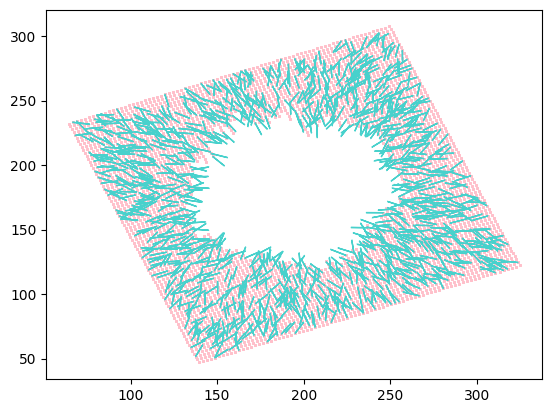

In [8]:
plotter.plot_train_data(train_data)

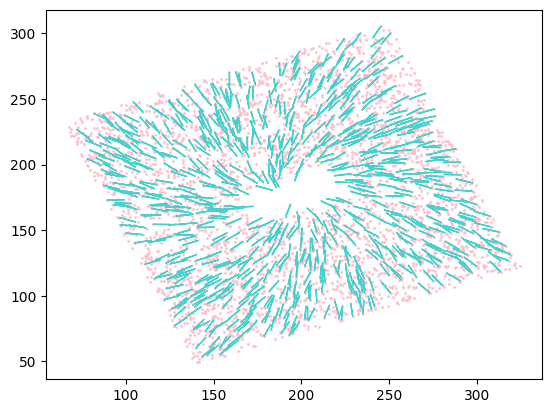

In [9]:
plotter.plot_data(val_data)

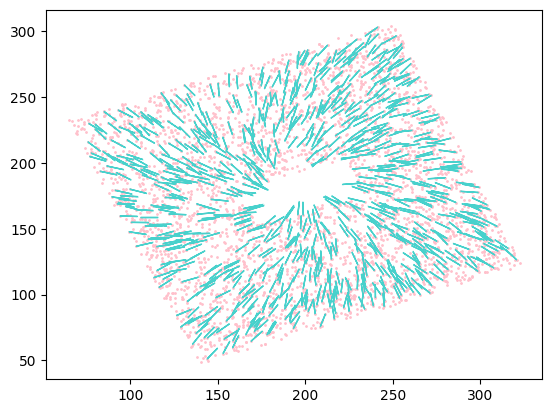

In [10]:
plotter.plot_data(test_data)

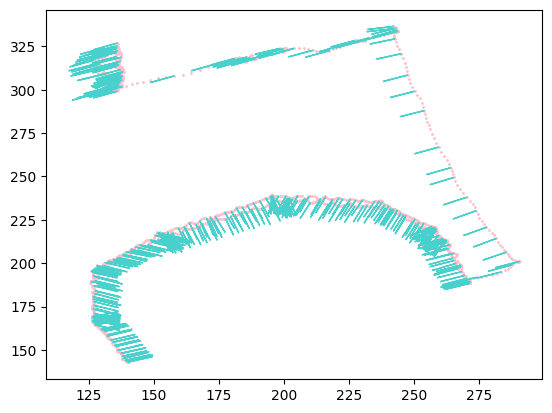

In [11]:
plotter.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


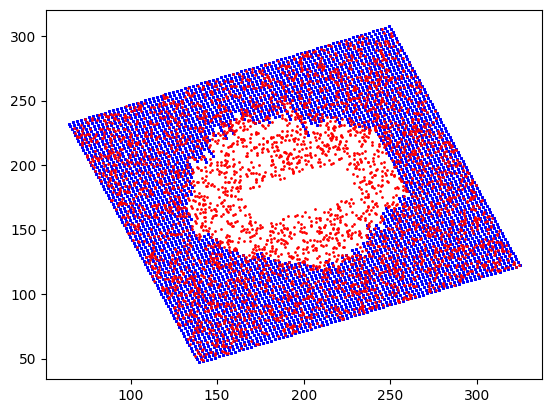

In [13]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2080.45it/s]


Validation after filtering: 3253


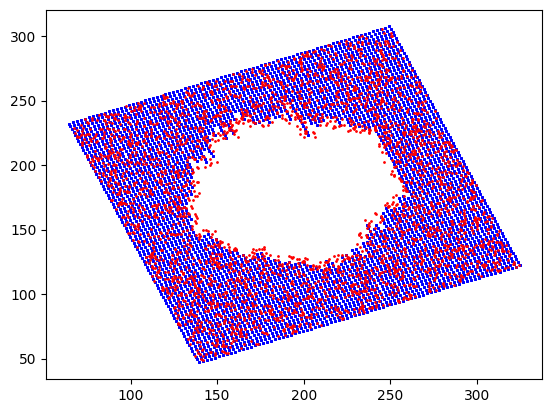

In [14]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


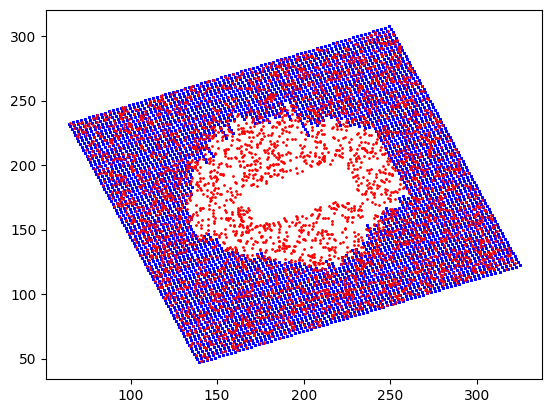

In [15]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2103.19it/s]


Test after filtering: 3271


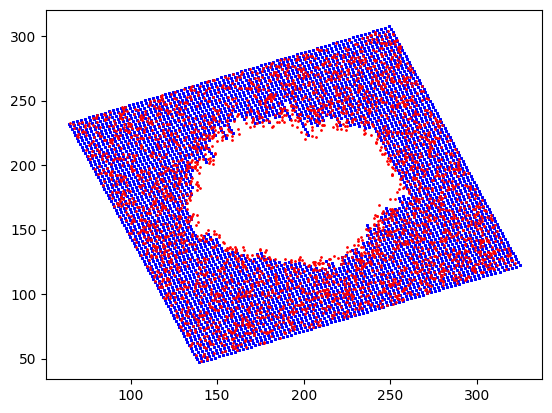

In [16]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.0
yaw difference tensor(65.3736) deg
localization error:  5.222905 meters


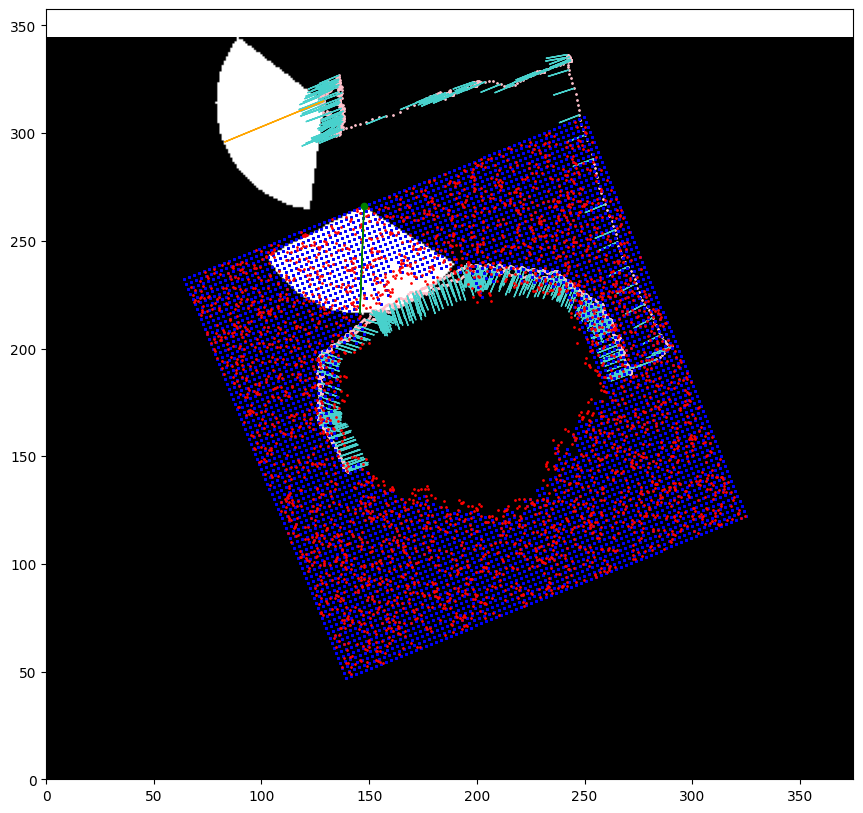

<Figure size 640x480 with 0 Axes>

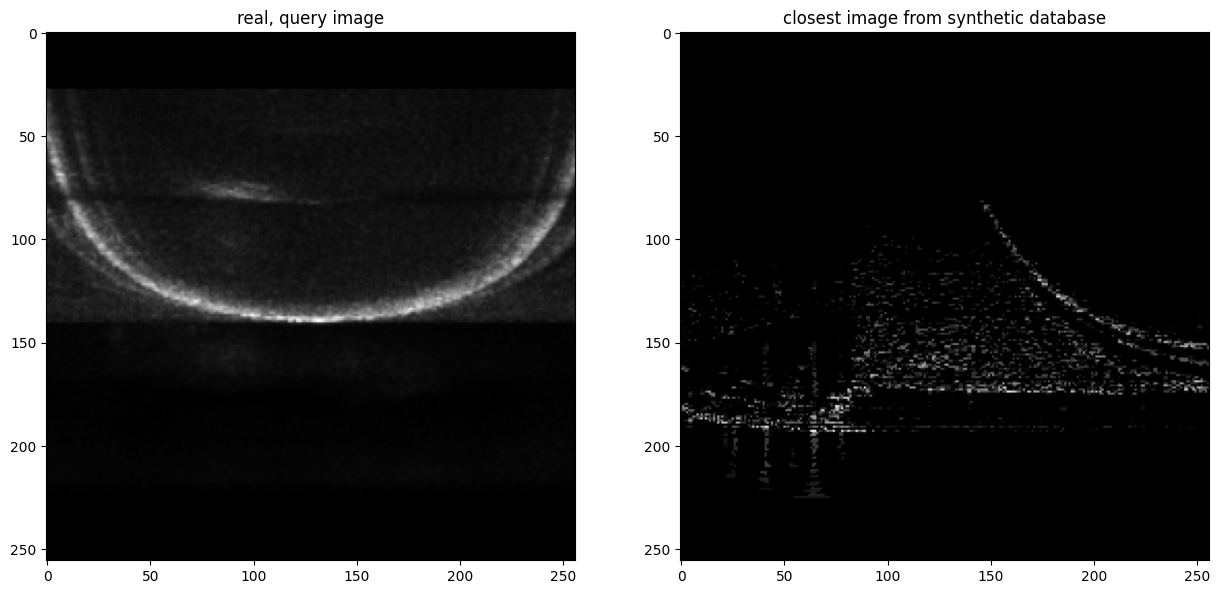

In [17]:
visualizer.localization(train_data, val_data, real_data)

In [18]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [19]:
val_data = visualizer.check_gt(train_data, val_data)

In [20]:
test_data = visualizer.check_gt(train_data, test_data)

In [21]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3269


In [22]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [23]:
model_name = "PVT"

In [24]:
net = pvt.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [25]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [26]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  20571337


## Training Pipeline

### Train epochs

In [27]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1501/1501 [23:55<00:00,  1.05it/s]


train loss mean: 4.864682242057431
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:05<00:00, 97.88it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.71it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:03<00:00,  7.68it/s]


average localization error: 11.6027 meters
average orientation error : 87.9179 degrees
epoch: 2


100%|███████████████████████████████████████| 1501/1501 [23:55<00:00,  1.05it/s]


train loss mean: 0.004530688966633746
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:06<00:00, 97.46it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.95it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:04<00:00,  7.66it/s]


average localization error: 7.6835 meters
average orientation error : 60.4328 degrees
epoch: 3


100%|███████████████████████████████████████| 1501/1501 [23:41<00:00,  1.06it/s]


train loss mean: 0.0030067575868060296
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:11<00:00, 95.58it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 96.20it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:04<00:00,  7.66it/s]


average localization error: 4.5678 meters
average orientation error : 36.8883 degrees
epoch: 4


100%|███████████████████████████████████████| 1501/1501 [23:39<00:00,  1.06it/s]


train loss mean: 0.0035221030785802065
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:12<00:00, 95.13it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:34<00:00, 95.44it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:06<00:00,  7.63it/s]


average localization error: 2.1755 meters
average orientation error : 16.4339 degrees
epoch: 5


100%|███████████████████████████████████████| 1501/1501 [23:39<00:00,  1.06it/s]


train loss mean: 0.004151296532116607
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:06<00:00, 97.32it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.28it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:04<00:00,  7.65it/s]


average localization error: 2.2144 meters
average orientation error : 17.2256 degrees
epoch: 6


100%|███████████████████████████████████████| 1501/1501 [23:39<00:00,  1.06it/s]


train loss mean: 0.002875041226229117
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:07<00:00, 97.07it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:34<00:00, 95.36it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:05<00:00,  7.64it/s]


average localization error: 3.2954 meters
average orientation error : 27.5166 degrees
epoch: 7


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 8554.851944390828
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 99.15it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.41it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:03<00:00,  7.68it/s]


average localization error: 11.7153 meters
average orientation error : 89.6411 degrees
epoch: 8


100%|███████████████████████████████████████| 1501/1501 [23:38<00:00,  1.06it/s]


train loss mean: 0.0069659378303265785
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 99.05it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 99.71it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:05<00:00,  7.64it/s]


average localization error: 11.8148 meters
average orientation error : 89.6214 degrees
epoch: 9


100%|███████████████████████████████████████| 1501/1501 [23:37<00:00,  1.06it/s]


train loss mean: 0.004719289234851169
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:02<00:00, 99.13it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 97.53it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:08<00:00,  7.58it/s]


average localization error: 11.9693 meters
average orientation error : 92.3489 degrees
epoch: 10


100%|███████████████████████████████████████| 1501/1501 [23:35<00:00,  1.06it/s]


train loss mean: 0.0036580846725598843
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.66it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 95.73it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:05<00:00,  7.65it/s]


average localization error: 11.5789 meters
average orientation error : 88.1326 degrees
epoch: 11


100%|███████████████████████████████████████| 1501/1501 [23:35<00:00,  1.06it/s]


train loss mean: 0.0029591213581992995
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:05<00:00, 97.83it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:33<00:00, 98.03it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:05<00:00,  7.63it/s]


average localization error: 11.7473 meters
average orientation error : 90.1550 degrees
epoch: 12


100%|███████████████████████████████████████| 1501/1501 [23:36<00:00,  1.06it/s]


train loss mean: 0.002687453246705835
computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.50it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 99.70it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3251/3251 [07:05<00:00,  7.65it/s]


average localization error: 7.1114 meters
average orientation error : 55.6200 degrees
Training time:  25506.9084815979 seconds


In [28]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.0018074661493301392 seconds


In [29]:
metrics.get_descriptors(train_data, val_data, net)

100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.71it/s]


computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:03<00:00, 98.52it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:32<00:00, 98.91it/s]


descriptors computed!
torch.Size([3251]) torch.Size([3251, 5])
avg_metric_e     : tensor(115.6612)
avg_metric_e_top5: tensor(51.5673)


## Visualize Training results on Test data

### Load the checkpoint model

In [32]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
net = pvt.Model()
states.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

Best model path:  correct_model_3/epoch_04.pth


### Compute the final descriptors of the training data

### Query the database

In [33]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:14<00:00, 94.45it/s]

descriptors computed!


### Visualize query results: sonar images

In [34]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-2.1396, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.2362, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-6.6824, device='cuda:0', grad_fn=<MinBackward1>) tensor(5.2779, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-21.0473, device='cuda:0', grad_fn=<MinBackward1>) tensor(20.4771, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-8.1232, device='cuda:0', grad_fn=<MinBackward1>) tensor(10.2195, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.6518, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5553, device='cuda:0', grad_fn=<MaxBackward1>)


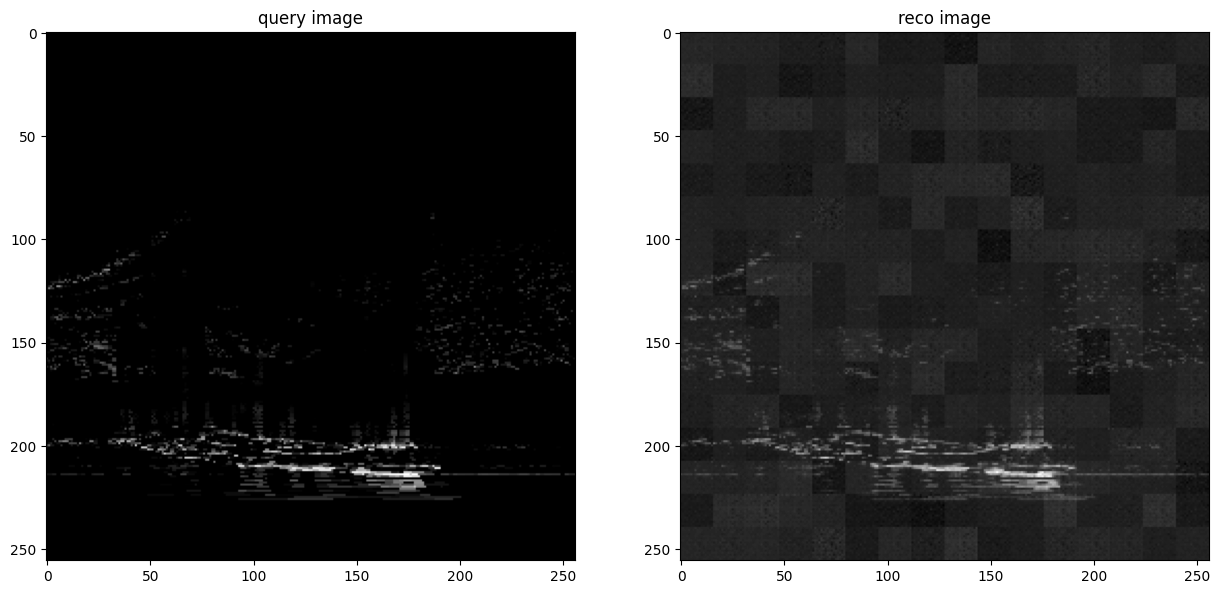

In [35]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.8632583763352012
localization error: 0.5000 meters
orientation error : 3.4084 degrees


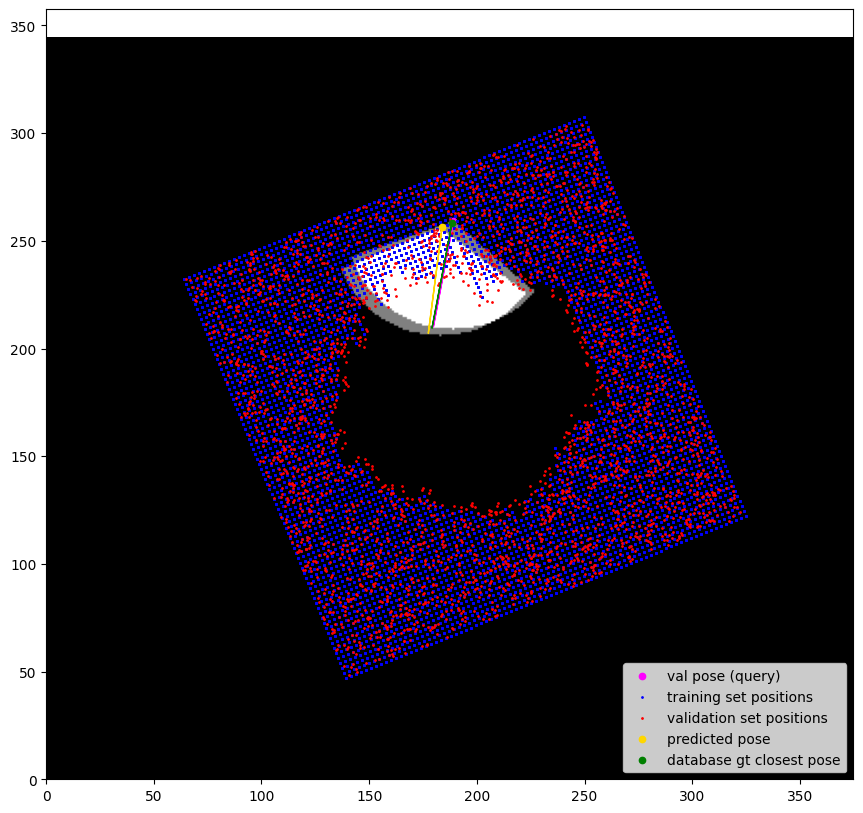

<Figure size 640x480 with 0 Axes>

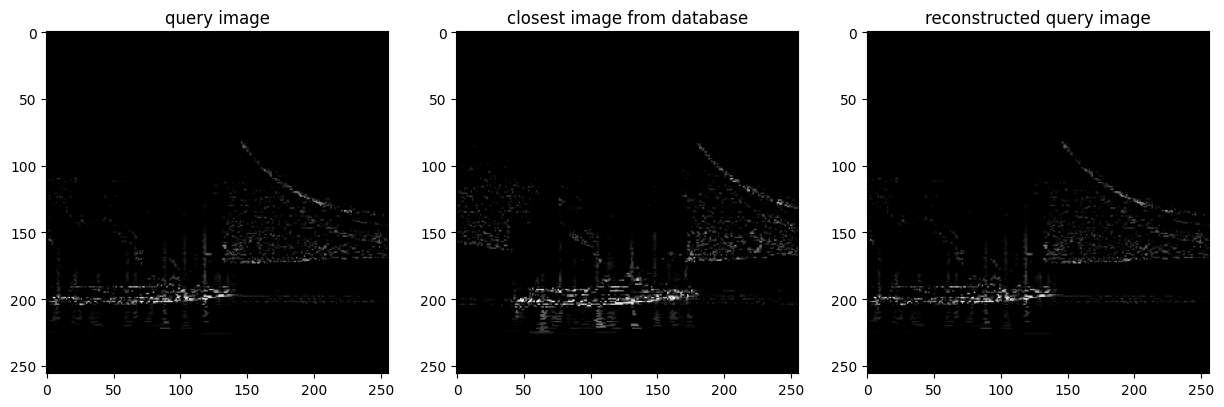

In [36]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [37]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 3269/3269 [07:16<00:00,  7.49it/s]

average localization error: 2.2148 meters
average orientation error : 17.1485 degrees


In [38]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [39]:
loca_errors.argmax()

np.int64(2881)

In [40]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

1.3462025
8.841937


## Process real images

query_idx: 160
201.71997 236.95007 2.6275423 -29.452927
iou: 0.13213559063697838
localization error Upper:  6.583356 meters


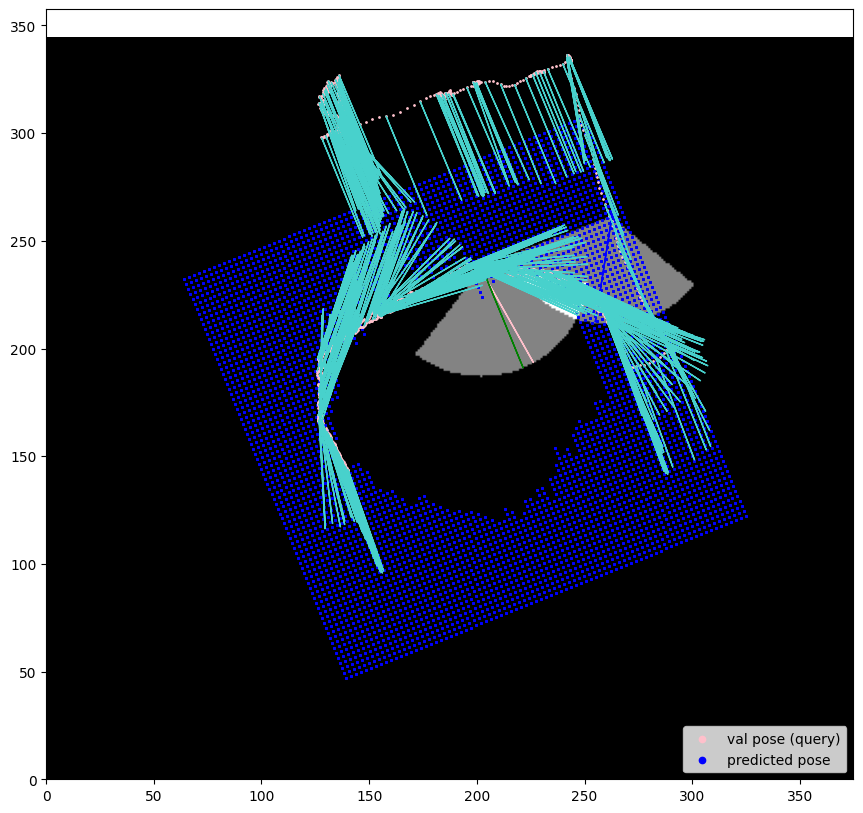

<Figure size 640x480 with 0 Axes>

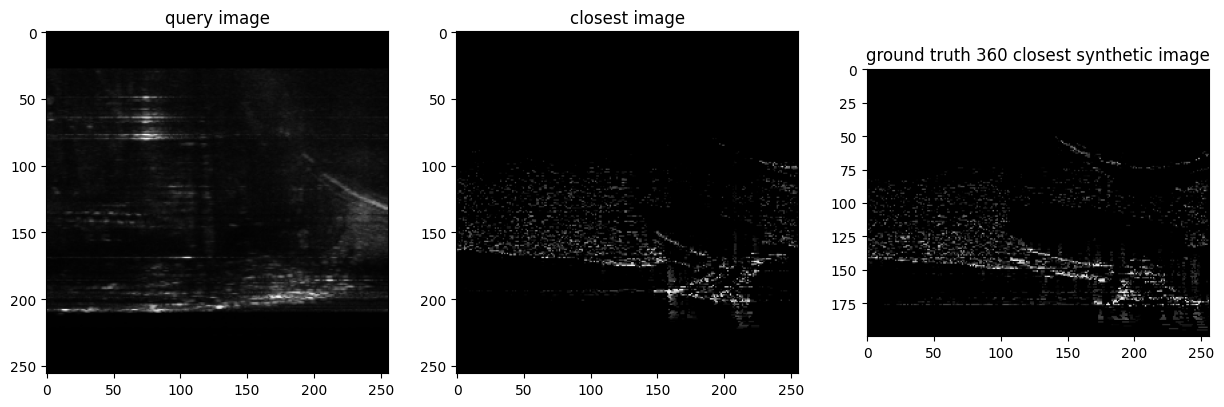

In [41]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [42]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [43]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:08<00:00, 80.41it/s]

descriptors computed!


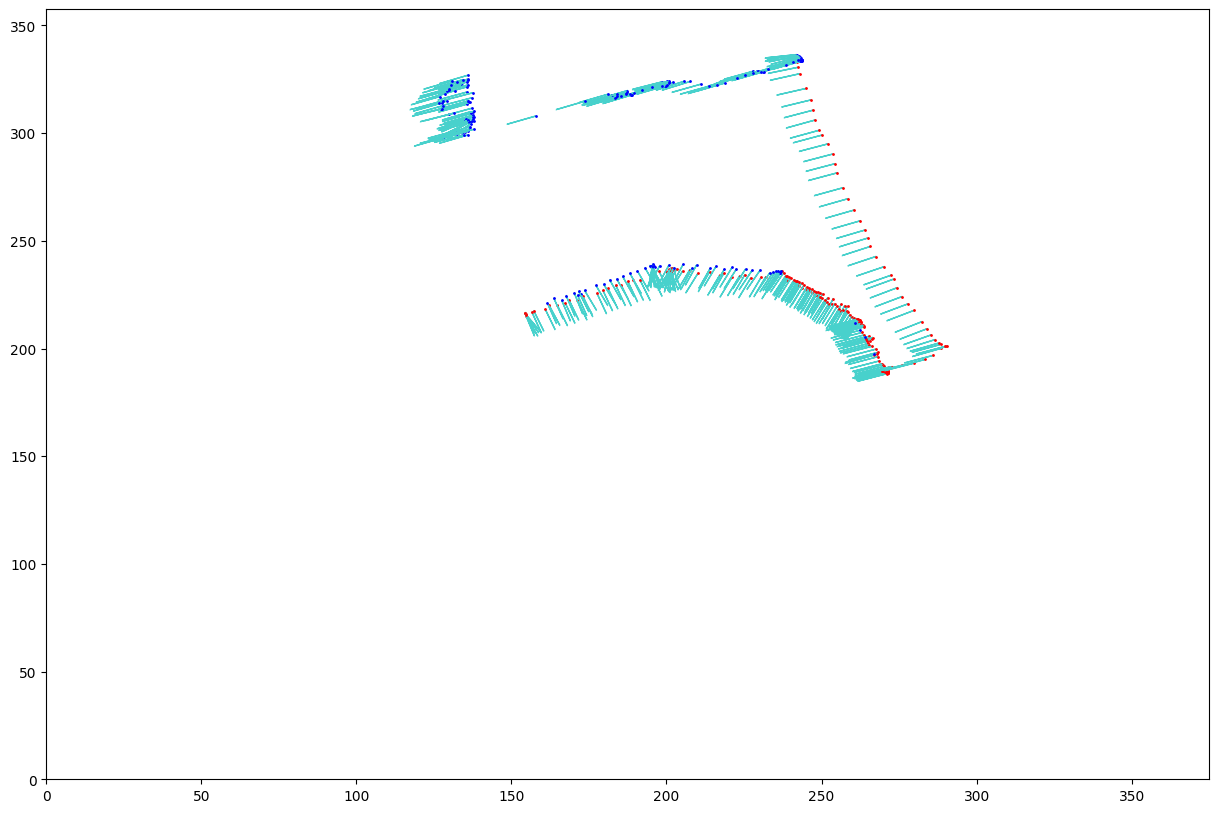

In [44]:
visualizer.visualize_real(train_data, real_data)

iou: 0.5518833876799485
localization error: 3.0988 meters
orientation error : 28.1093 degrees


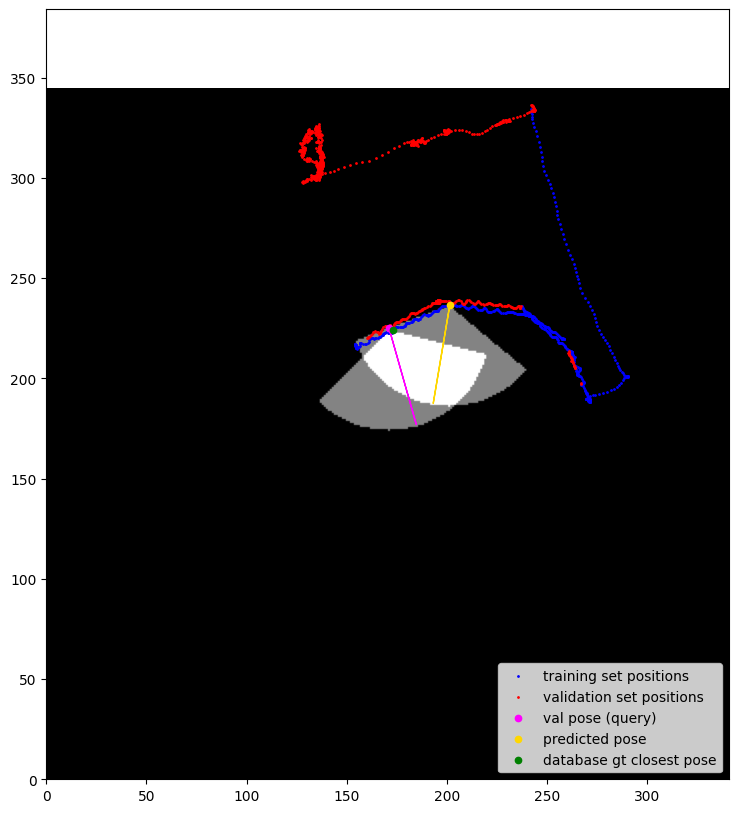

<Figure size 640x480 with 0 Axes>

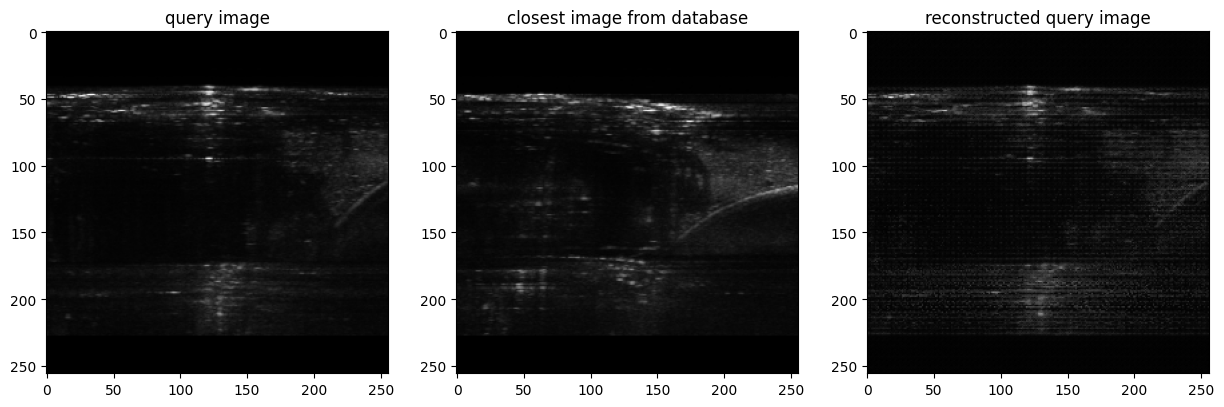

In [45]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [46]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:21<00:00, 36.93it/s]

average localization error: 5.5749 meters
average orientation error : 41.3790 degrees


In [47]:
avg_orie_error.min()

np.float32(41.37896)

## Results

In [57]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

Model name: PVT
Total parameters: 20571337
Training time: 25506.9085 seconds
Inference time per image: 0.0018 seconds
Average localization error in Test: 2.2148 meters
Average orientation error in Test: 17.1485 degrees
Average localization error in Real: 5.5749 meters
Average orientation error in Real: 41.3790 degrees
